1-implementation of harris feature detector:

a) First, import both pictures. As a preprocessing step, apply a Gaussian filter to reduce noise. It is also highly recommended to convert the images to grayscale. (In this section, you can use prebuilt libraries.)

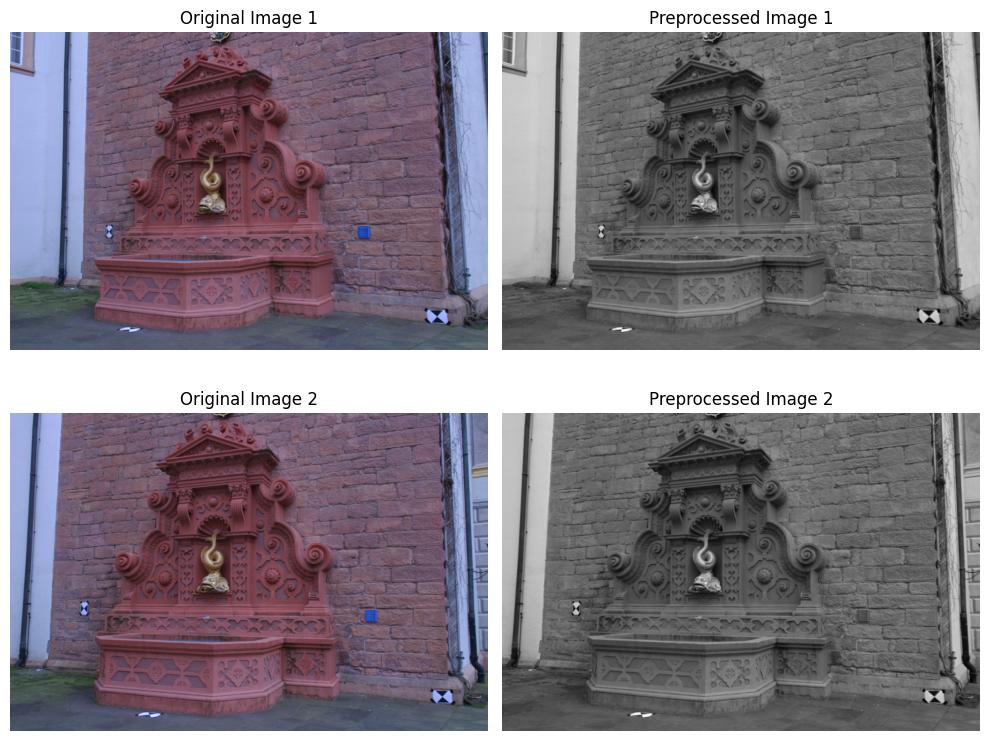

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def plot_images(images, titles, figsize=(10, 8)):
    """
    Plots multiple images in a grid format.

    :param images: List of images to be plotted.
    :param titles: List of titles for the images.
    :param figsize: Size of the figure.
    """
    n = len(images)
    rows = (n + 1) // 2

    plt.figure(figsize=figsize)

    for i in range(n):
        plt.subplot(rows, 2, i + 1)
        if len(images[i].shape) == 2:
            plt.imshow(images[i], cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(titles[i])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Load the images
img1 = cv2.imread('img1.png')
img2 = cv2.imread('img2.png')

# Convert the images to grayscale
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Apply Gaussian filter to reduce noise
gray1_blur = cv2.GaussianBlur(gray1, (5, 5), 0)
gray2_blur = cv2.GaussianBlur(gray2, (5, 5), 0)

# Prepare images and titles for plotting
images = [img1, gray1_blur, img2, gray2_blur]
titles = ['Original Image 1', 'Preprocessed Image 1', 'Original Image 2', 'Preprocessed Image 2']
plot_images(images, titles)

b) as you know for detecting corners you need to find to image gradients so compute the image gradients in 2 directions. use libraries for this purpose.

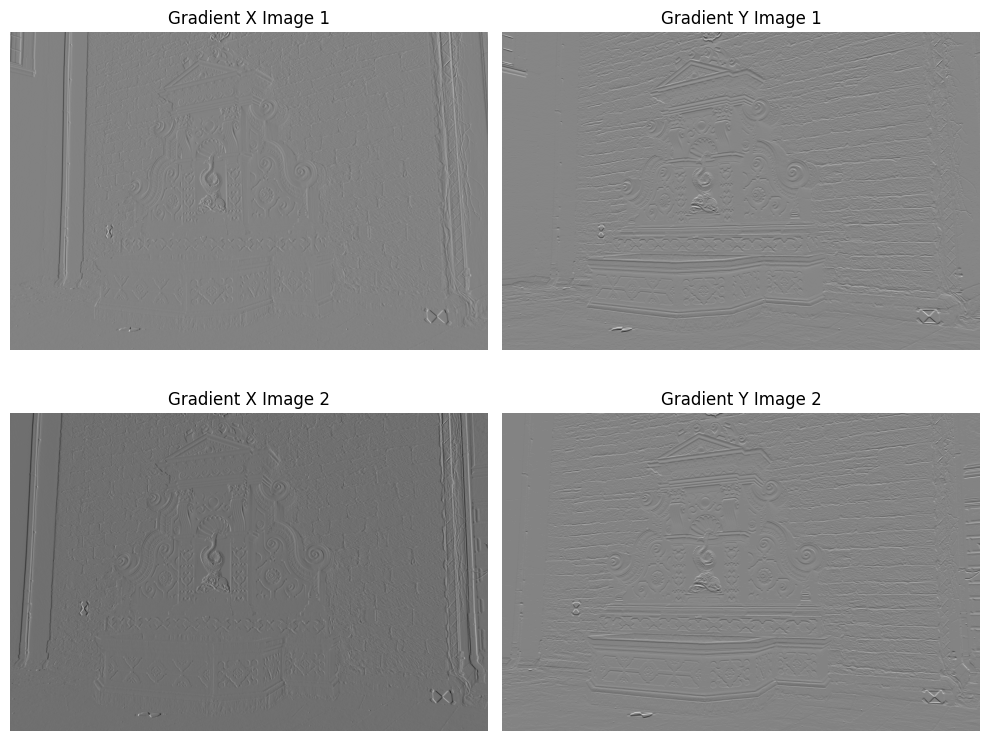

In [2]:
grad_x1 = cv2.Sobel(gray1_blur, cv2.CV_64F, 1, 0, ksize=3)
grad_y1 = cv2.Sobel(gray1_blur, cv2.CV_64F, 0, 1, ksize=3)
grad_x2 = cv2.Sobel(gray2_blur, cv2.CV_64F, 1, 0, ksize=3)
grad_y2 = cv2.Sobel(gray2_blur, cv2.CV_64F, 0, 1, ksize=3)

images = [grad_x1, grad_y1, grad_x2, grad_y2]
titles = ['Gradient X Image 1', 'Gradient Y Image 1', 'Gradient X Image 2', 'Gradient Y Image 2']

plot_images(images, titles)

c) Compute the Harris corner response for each pixel. Use an arbitrary value for the window size. You are not allowed to use prebuilt libraries for the Harris corner detector.

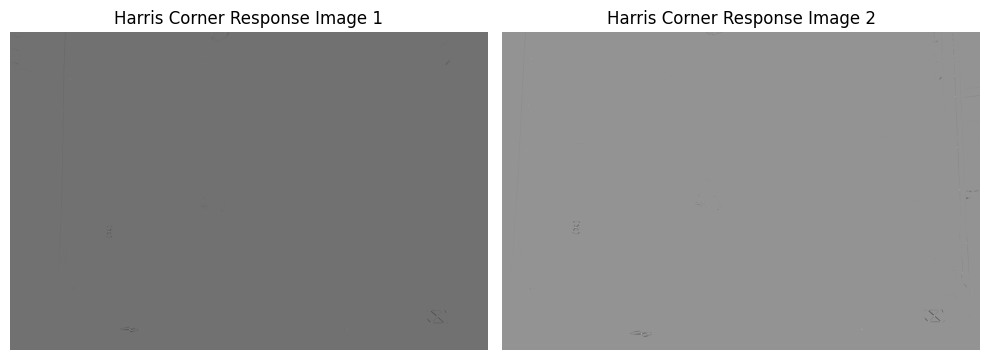

In [3]:
Ixx1 = grad_x1**2
Ixy1 = grad_x1*grad_y1
Iyy1 = grad_y1**2

Ixx2 = grad_x2**2
Ixy2 = grad_x2*grad_y2
Iyy2 = grad_y2**2

Ixx1 = cv2.GaussianBlur(Ixx1, (5, 5), 0)
Ixy1 = cv2.GaussianBlur(Ixy1, (5, 5), 0)
Iyy1 = cv2.GaussianBlur(Iyy1, (5, 5), 0)

Ixx2 = cv2.GaussianBlur(Ixx2, (5, 5), 0)
Ixy2 = cv2.GaussianBlur(Ixy2, (5, 5), 0)
Iyy2 = cv2.GaussianBlur(Iyy2, (5, 5), 0)

def harris_response(Ixx, Ixy, Iyy, k=0.04):
    detM = (Ixx * Iyy) - (Ixy ** 2)
    traceM = Ixx + Iyy
    R = detM - k * (traceM ** 2)
    return R

R1 = harris_response(Ixx1, Ixy1, Iyy1)
R2 = harris_response(Ixx2, Ixy2, Iyy2)

R1_norm = cv2.normalize(R1, None, 0, 255, cv2.NORM_MINMAX)
R2_norm = cv2.normalize(R2, None, 0, 255, cv2.NORM_MINMAX)

images = [R1_norm, R2_norm]
titles = ['Harris Corner Response Image 1', 'Harris Corner Response Image 2']

plot_images(images, titles)


d)  Identify a set of pixels where the Harris response exceeds a specified, arbitrary threshold value of α.

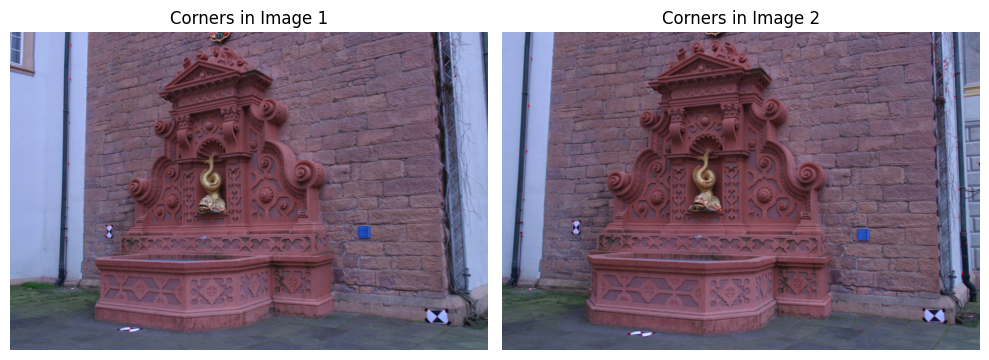

In [4]:
alpha = 0.01 * R1.max()
corners1 = R1 > alpha

alpha = 0.01 * R2.max()
corners2 = R2 > alpha

img1_corners = img1.copy()
# Mark corners with red color
img1_corners[corners1] = [0, 0, 255]  

img2_corners = img2.copy()
# Mark corners with red color
img2_corners[corners2] = [0, 0, 255]

images = [img1_corners, img2_corners]
titles = ['Corners in Image 1', 'Corners in Image 2']

plot_images(images, titles)

e) apply non-maximal suppression within an arbitrary w×w pixel neighborhood around each candidate pixel to extract the most significant corners.


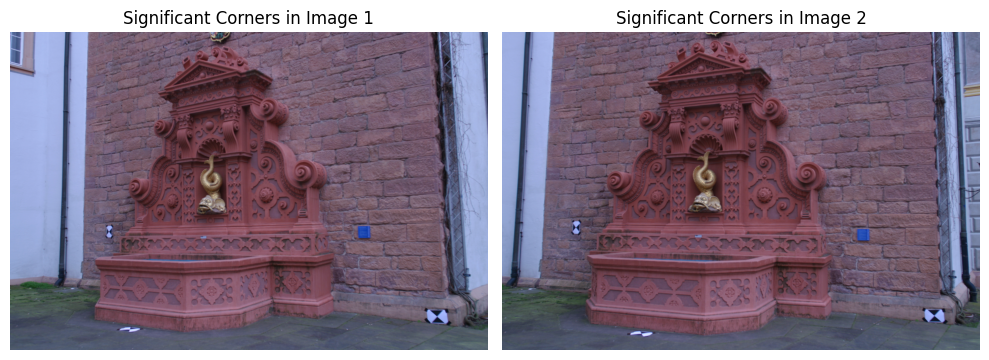

In [6]:
def non_max_suppression(R, window_size=3):
    rows, cols = R.shape
    R_suppressed = np.zeros((rows, cols))
    half_size = window_size // 2
    
    for y in range(half_size, rows - half_size):
        for x in range(half_size, cols - half_size):
            window = R[y - half_size:y + half_size + 1, x - half_size:x + half_size + 1]
            if R[y, x] == np.max(window):
                R_suppressed[y, x] = R[y, x]
    
    return R_suppressed

R1_suppressed = non_max_suppression(R1, window_size=3)
R2_suppressed = non_max_suppression(R2, window_size=3)

# Thresholding to identify strong corners after NMS
corners1_suppressed = R1_suppressed > alpha
corners2_suppressed = R2_suppressed > alpha

# Highlight the corners on the original images
img1_corners = img1.copy()
img1_corners[corners1_suppressed] = [0, 0, 255]  # Mark corners with red color

img2_corners = img2.copy()
img2_corners[corners2_suppressed] = [0, 0, 255]  # Mark corners with red color

f) Visualize the input images with highlighted corners

In [ ]:
images = [img1_corners, img2_corners]
titles = ['Significant Corners in Image 1', 'Significant Corners in Image 2']

plot_images(images, titles)

g) Test and analyze the impact of:


i. Different values of the Gaussian window size (in part a)

### تاثیر مقادیر مختلف اندازه پنجره گاوسی

اندازه پنجره گاوسی، که به عنوان اندازه هسته نیز شناخته می‌شود، نقش حیاتی در مرحله پیش‌پردازش دارد که در آن فیلتر گاوسی برای کاهش نویز به تصویر اعمال می‌شود. این پارامتر تأثیر قابل توجهی بر نتایج تشخیص گوشه هریس دارد. در اینجا چگونگی این تأثیر آمده است:

1. **اندازه پنجره گاوسی:**
   - اندازه پنجره گاوسی اندازه هسته مورد استفاده برای بلور گاوسی را تعریف می‌کند. این اندازه باید یک عدد فرد باشد (مثلاً 3x3، 5x5، 7x7).
   - هرچه اندازه هسته بزرگتر باشد، بلور بیشتری به تصویر اعمال می‌شود.

#### تاثیر بر تشخیص گوشه هریس:
1. **اندازه هسته کوچک (مثلاً 3x3):**
   - **بلور کمتر:** اندازه‌های هسته کوچکتر منجر به بلور کمتری از تصویر می‌شوند، به این معنا که جزئیات دقیق و نویز بیشتر قابل مشاهده هستند.
   - **تشخیص جزئیات دقیق:** گوشه‌ها و لبه‌هایی که بسیار نزدیک به یکدیگر هستند، می‌توانند راحت‌تر تشخیص داده شوند.
   - **حساسیت به نویز:** در حالی که جزئیات دقیق حفظ می‌شوند، تشخیص گوشه نیز ممکن است به نویز و ویژگی‌های نادرست پاسخ دهد که منجر به مثبت‌های کاذب شود.

2. **اندازه هسته متوسط (مثلاً 5x5):**
   - **بلور متعادل:** تعادلی بین حفظ جزئیات مهم و کاهش نویز فراهم می‌کند.
   - **تشخیص موثر:** مناسب برای تشخیص بیشتر گوشه‌ها در حالی که به حداقل رساندن تشخیص نویز.
   - **استفاده عمومی:** به طور معمول به عنوان یک انتخاب استاندارد برای بسیاری از کاربردها استفاده می‌شود زیرا توازن خوبی ارائه می‌دهد.

3. **اندازه هسته بزرگ (مثلاً 7x7 یا بزرگتر):**
   - **بلور بیشتر:** اندازه‌های هسته بزرگتر منجر به بلور بیشتری می‌شوند که می‌تواند جزئیات دقیق را از بین ببرد.
   - **کاهش نویز:** موثر در کاهش نویز، که در تصاویر پرنویز مفید است.
   - **از دست دادن جزئیات دقیق:** در حالی که نویز را کاهش می‌دهد، جزئیات مهم از جمله گوشه‌های نزدیک به هم ممکن است از دست بروند که منجر به تشخیص گوشه‌های کمتر می‌شود.


ii. Different values of window size in part c.


### تاثیر مقادیر مختلف اندازه پنجره در بخش (ج)

اندازه پنجره، که در محاسبه پاسخ گوشه هریس استفاده می‌شود، نقش مهمی در تشخیص گوشه‌ها ایفا می‌کند. این پارامتر تعیین می‌کند که در هر پیکسل، چه اندازه ناحیه‌ای از تصویر باید مورد بررسی قرار گیرد تا ماتریس M محاسبه شود. در اینجا نحوه تاثیر اندازه پنجره بر نتایج تشخیص گوشه توضیح داده شده است:

1. **اندازه پنجره:**
   - اندازه پنجره به تعداد پیکسل‌هایی اشاره دارد که در هر جهت از یک پیکسل مرکزی برای محاسبه ماتریس M در نظر گرفته می‌شود.
   - اندازه پنجره باید یک عدد فرد باشد تا یک پیکسل مرکزی برای مقایسه وجود داشته باشد (مثلاً 3x3، 5x5، 7x7).

#### تاثیر بر تشخیص گوشه هریس:
1. **اندازه پنجره کوچک (مثلاً 3x3):**
   - **حساسیت بالا به جزئیات محلی:** پنجره کوچک به تغییرات کوچک در تصویر حساس است و می‌تواند گوشه‌های دقیق و نزدیک به هم را تشخیص دهد.
   - **حساسیت به نویز:** در حالی که گوشه‌های دقیق تشخیص داده می‌شوند، این پنجره‌ها به نویز تصویر نیز حساس هستند که می‌تواند منجر به تشخیص گوشه‌های کاذب شود.

2. **اندازه پنجره متوسط (مثلاً 5x5):**
   - **تعادل بین جزئیات و کاهش نویز:** پنجره متوسط می‌تواند تعادل خوبی بین تشخیص جزئیات و کاهش تاثیر نویز ایجاد کند.
   - **تشخیص موثر گوشه‌ها:** این اندازه پنجره برای بیشتر تصاویر مناسب است و می‌تواند گوشه‌ها را با دقت خوبی تشخیص دهد در حالی که از تشخیص نویز جلوگیری می‌کند.

3. **اندازه پنجره بزرگ (مثلاً 7x7 یا بزرگتر):**
   - **کاهش حساسیت به نویز:** پنجره بزرگتر باعث کاهش حساسیت به نویز می‌شود زیرا ناحیه بزرگتری از تصویر را برای محاسبه در نظر می‌گیرد.
   - **از دست دادن جزئیات دقیق:** با این حال، این پنجره ممکن است گوشه‌های کوچک و دقیق را از دست بدهد و به جای آن گوشه‌های بزرگتر و واضح‌تر را تشخیص دهد.

iii. Different values of threshold α. (part d)


<!DOCTYPE html>
<html lang="fa" dir="rtl">
<head>
    <meta charset="UTF-8">
    <title>تاثیر مقادیر مختلف آستانه α</title>
    <style>
        body {
            direction: rtl;
            font-family: Arial, sans-serif;
        }
        h1, h2, h3, h4, h5, h6 {
            text-align: right;
        }
        p, ul, li {
            text-align: right;
        }
    </style>
</head>
<body>

<h3>تاثیر مقادیر مختلف آستانه α (بخش د)</h3>

<p>آستانه α در تشخیص گوشه‌ها نقش مهمی دارد، زیرا تعیین می‌کند که کدام پاسخ‌های گوشه به عنوان گوشه‌های قوی در نظر گرفته شوند. تنظیم آستانه تأثیر مستقیمی بر تعداد و کیفیت گوشه‌های تشخیص داده شده دارد. در اینجا نحوه تأثیر مقادیر مختلف آستانه α بر نتایج تشخیص گوشه توضیح داده شده است:</p>

<h4>توضیحات:</h4>
<ol>
    <li><strong>آستانه α:</strong>
        <ul>
            <li>آستانه α مقداری است که پاسخ گوشه‌ها با آن مقایسه می‌شود. اگر پاسخ گوشه‌ای بیشتر از این مقدار باشد، به عنوان گوشه قوی در نظر گرفته می‌شود.</li>
            <li>مقدار آستانه به صورت نسبتی از حداکثر مقدار پاسخ گوشه‌ها تعیین می‌شود (مثلاً 0.01 * حداکثر مقدار پاسخ).</li>
        </ul>
    </li>
</ol>

<h4>تاثیر بر تشخیص گوشه هریس:</h4>
<ol>
    <li><strong>آستانه کم (مثلاً 0.01):</strong>
        <ul>
            <li><strong>تشخیص گوشه‌های بیشتر:</strong> آستانه پایین‌تر منجر به تشخیص تعداد بیشتری گوشه می‌شود، زیرا بسیاری از پاسخ‌های گوشه ممکن است از این مقدار عبور کنند.</li>
            <li><strong>حساسیت به نویز:</strong> در حالی که گوشه‌های بیشتری تشخیص داده می‌شوند، ممکن است گوشه‌های کاذب نیز شناسایی شوند که در واقع نویز هستند.</li>
        </ul>
    </li>
    <li><strong>آستانه متوسط (مثلاً 0.05):</strong>
        <ul>
            <li><strong>تعادل بین گوشه‌های واقعی و کاذب:</strong> آستانه متوسط می‌تواند تعادل خوبی بین تشخیص گوشه‌های واقعی و کاهش تشخیص گوشه‌های کاذب ایجاد کند.</li>
            <li><strong>تشخیص گوشه‌های موثر:</strong> این مقدار آستانه برای بیشتر تصاویر مناسب است و گوشه‌های قوی را با دقت تشخیص می‌دهد.</li>
        </ul>
    </li>
    <li><strong>آستانه بالا (مثلاً 0.1):</strong>
        <ul>
            <li><strong>کاهش گوشه‌های کاذب:</strong> آستانه بالاتر منجر به کاهش تعداد گوشه‌های تشخیص داده شده می‌شود، زیرا فقط پاسخ‌های گوشه با مقادیر بالاتر از این آستانه تشخیص داده می‌شوند.</li>
            <li><strong>از دست دادن گوشه‌های ضعیف:</strong> در حالی که گوشه‌های کاذب کاهش می‌یابند، گوشه‌های ضعیف‌تر نیز ممکن است نادیده گرفته شوند و فقط گوشه‌های بسیار قوی تشخیص داده شوند.</li>
        </ul>
    </li>
</ol>
</body>
</html>


ii. Different values of non-maximal suppression window size(w*w) in part e.


### تاثیر مقادیر مختلف اندازه پنجره حذف غیرماکزیمال (w×w) در بخش (هـ)

حذف غیرماکزیمال (NMS) فرآیندی است که برای انتخاب مهمترین گوشه‌ها با حذف گوشه‌های ضعیف‌تر در یک ناحیه محلی استفاده می‌شود. اندازه پنجره NMS نقش مهمی در انتخاب نهایی گوشه‌ها ایفا می‌کند. این پارامتر تعیین می‌کند که در هر پیکسل، چه اندازه ناحیه‌ای از تصویر باید برای مقایسه و انتخاب ماکزیمم محلی بررسی شود. در اینجا نحوه تاثیر اندازه پنجره NMS بر نتایج تشخیص گوشه توضیح داده شده است:

1. **اندازه پنجره NMS:**
   - اندازه پنجره NMS به تعداد پیکسل‌هایی اشاره دارد که در هر جهت از یک پیکسل مرکزی برای مقایسه و انتخاب ماکزیمم محلی در نظر گرفته می‌شود.
   - اندازه پنجره باید یک عدد فرد باشد تا یک پیکسل مرکزی برای مقایسه وجود داشته باشد (مثلاً 3x3، 5x5، 7x7).

#### تاثیر بر تشخیص گوشه هریس:
1. **اندازه پنجره کوچک (مثلاً 3x3):**
   - **حساسیت به جزئیات دقیق:** پنجره کوچک فقط ناحیه کوچکی از پیکسل‌ها را برای انتخاب ماکزیمم محلی بررسی می‌کند. این باعث می‌شود گوشه‌های نزدیک به هم حفظ شوند.
   - **حذف گوشه‌های کاذب کمتر:** ممکن است برخی گوشه‌های ضعیف‌تر به عنوان گوشه‌های مهم باقی بمانند.

2. **اندازه پنجره متوسط (مثلاً 5x5):**
   - **تعادل بین جزئیات و حذف گوشه‌های کاذب:** پنجره متوسط می‌تواند تعادل خوبی بین حفظ گوشه‌های مهم و حذف گوشه‌های ضعیف‌تر ایجاد کند.
   - **تشخیص موثر گوشه‌ها:** این اندازه پنجره برای بیشتر تصاویر مناسب است و گوشه‌های قوی‌تر را با دقت بیشتری انتخاب می‌کند.

3. **اندازه پنجره بزرگ (مثلاً 7x7 یا بزرگتر):**
   - **حذف گوشه‌های ضعیف:** پنجره بزرگتر باعث می‌شود ناحیه بزرگتری از پیکسل‌ها برای انتخاب ماکزیمم محلی بررسی شود. این باعث حذف گوشه‌های ضعیف‌تر می‌شود.
   - **از دست دادن گوشه‌های نزدیک به هم:** ممکن است گوشه‌های نزدیک به هم حذف شوند و فقط گوشه‌های قوی‌تر باقی بمانند.


h) For matching the corner points between two images, we need to assign a descriptor to each feature point. There are different types of descriptors; some are just translation invariant, while some of them are both translation and rotation invariant and etc. One of the most recognized descriptors is MOPS, which is translation and rotation invariant, making it a good choice for many applications. We want to use a simplified MOPS algorithm to calculate descriptors for each corner. (you can read more about MOPS at: https://sbme-tutorials.github.io/2020/cv/presentations/week06_sift.html#5)

first Find the dominant orientation θ of the each keypoint. Each keypoint now is represented by (x,y,θ) 

Extract an 8×8 patch around the keypoint then Estimate the local mean and the std of intensities in the 8x8 and normaize the intensities. now each keypoint is represented by (x,y,θ,Ihat) 

Write a function based on the mentioned two steps. Lastly, use prebuilt OpenCV functions for the matching operation (output of MOPS function is input of opencv matching functions.)

Feel free to incorporate creativity and innovation in this part. There's a high chance that you may not achieve an ideal result because this is a basic and simplified descriptor

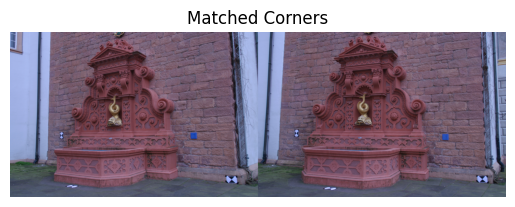

In [7]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def plot_images(images, titles, figsize=(10, 8)):
    n = len(images)
    rows = (n + 1) // 2

    plt.figure(figsize=figsize)

    for i in range(n):
        plt.subplot(rows, 2, i + 1)
        if len(images[i].shape) == 2:  # Grayscale image
            plt.imshow(images[i], cmap='gray')
        else:  # Color image
            plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(titles[i])
        plt.axis('off')  # Hide axes for better visualization

    plt.tight_layout()
    plt.show()

# Load the images
img1 = cv2.imread('img1.png')
img2 = cv2.imread('img2.png')

# Convert the images to grayscale
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Detect Harris corners
def harris_response(Ixx, Ixy, Iyy, k=0.04):
    detM = (Ixx * Iyy) - (Ixy ** 2)
    traceM = Ixx + Iyy
    R = detM - k * (traceM ** 2)
    return R

def compute_gradients(img):
    grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    return grad_x, grad_y

grad_x1, grad_y1 = compute_gradients(gray1)
grad_x2, grad_y2 = compute_gradients(gray2)

Ixx1, Ixy1, Iyy1 = grad_x1**2, grad_x1*grad_y1, grad_y1**2
Ixx2, Ixy2, Iyy2 = grad_x2**2, grad_x2*grad_y2, grad_y2**2

R1 = harris_response(Ixx1, Ixy1, Iyy1)
R2 = harris_response(Ixx2, Ixy2, Iyy2)

alpha = 0.01 * R1.max()
corners1 = np.argwhere(R1 > alpha)
alpha = 0.01 * R2.max()
corners2 = np.argwhere(R2 > alpha)

def find_dominant_orientation(grad_x, grad_y, keypoints):
    orientations = []
    for kp in keypoints:
        y, x = kp
        mag = np.sqrt(grad_x[y-1:y+2, x-1:x+2]**2 + grad_y[y-1:y+2, x-1:x+2]**2)
        ang = np.arctan2(grad_y[y-1:y+2, x-1:x+2], grad_x[y-1:y+2, x-1:x+2])
        hist, _ = np.histogram(ang, bins=36, range=(-np.pi, np.pi), weights=mag)
        dominant_orientation = np.argmax(hist) * 10 * np.pi / 180 - np.pi
        orientations.append(dominant_orientation)
    return orientations

orientations1 = find_dominant_orientation(grad_x1, grad_y1, corners1)
orientations2 = find_dominant_orientation(grad_x2, grad_y2, corners2)

def extract_and_normalize_patch(img, keypoints, orientations, patch_size=8):
    descriptors = []
    half_size = patch_size // 2
    for kp, theta in zip(keypoints, orientations):
        y, x = kp
        M = cv2.getRotationMatrix2D((x, y), -theta * 180 / np.pi, 1)
        patch = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
        patch = patch[y-half_size:y+half_size, x-half_size:x+half_size]
        if patch.shape != (patch_size, patch_size):
            continue
        patch = patch.astype(np.float32)
        patch = (patch - np.mean(patch)) / (np.std(patch) + 1e-5)
        descriptors.append(patch.flatten())
    return np.array(descriptors)

descriptors1 = extract_and_normalize_patch(gray1, corners1, orientations1)
descriptors2 = extract_and_normalize_patch(gray2, corners2, orientations2)

# Use OpenCV's BFMatcher to match the descriptors
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)

# Draw matches
img_matches = cv2.drawMatches(img1, [cv2.KeyPoint(c[1], c[0], 1) for c in corners1],
                              img2, [cv2.KeyPoint(c[1], c[0], 1) for c in corners2],
                              matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.title('Matched Corners')
plt.axis('off')
plt.show()


2-SIFT descriptor

The SIFT descriptor is one of the most, or perhaps the most, widely applicable feature detection algorithms that find keypoints and assigns a descriptor to each keypoints. SIFT extracts feature points in a pyramid space created from a picture at different sizes and scales. (you can read mor about sift at: https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html) 

Capture two images with your phone, ensuring that in the second image, your camera rotates +30 degrees and translates +15 cm (based on your assumption for positive directions and rotations)

dont capture the images from featureless environment such as a plain wall (if you can take a picture of chessboard)

a) find keypoints use sift prebuilt functions (dont forget the preprocess step!)

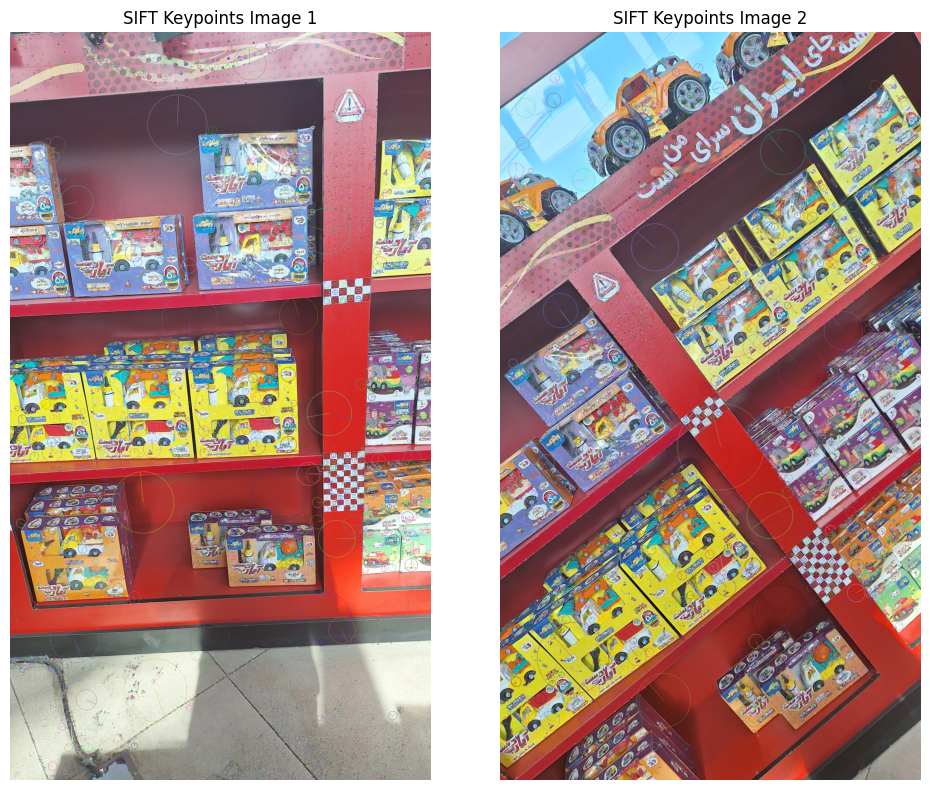

In [8]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def plot_images(images, titles, figsize=(10, 8)):
    n = len(images)
    rows = (n + 1) // 2  
    plt.figure(figsize=figsize)

    for i in range(n):
        plt.subplot(rows, 2, i + 1)
        if len(images[i].shape) == 2:  # Grayscale image
            plt.imshow(images[i], cmap='gray')
        else:  # Color image
            plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(titles[i])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

img1 = cv2.imread('actual.jpg')
img2 = cv2.imread('transformed.jpg')

gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

gray1_blur = cv2.GaussianBlur(gray1, (5, 5), 0)
gray2_blur = cv2.GaussianBlur(gray2, (5, 5), 0)

sift = cv2.SIFT_create()

keypoints1, descriptors1 = sift.detectAndCompute(gray1_blur, None)
keypoints2, descriptors2 = sift.detectAndCompute(gray2_blur, None)

img1_sift = cv2.drawKeypoints(img1, keypoints1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2_sift = cv2.drawKeypoints(img2, keypoints2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

images = [img1_sift, img2_sift]
titles = ['SIFT Keypoints Image 1', 'SIFT Keypoints Image 2']

plot_images(images, titles)


b) Utilize prebuilt matching functions to find the matches between two images. Identify the best two candidates for each match and select the matching as a true match based on your arbitrary conditions. Visualize the matches between the two images. Adjust your conditions to find the best matching result visually.

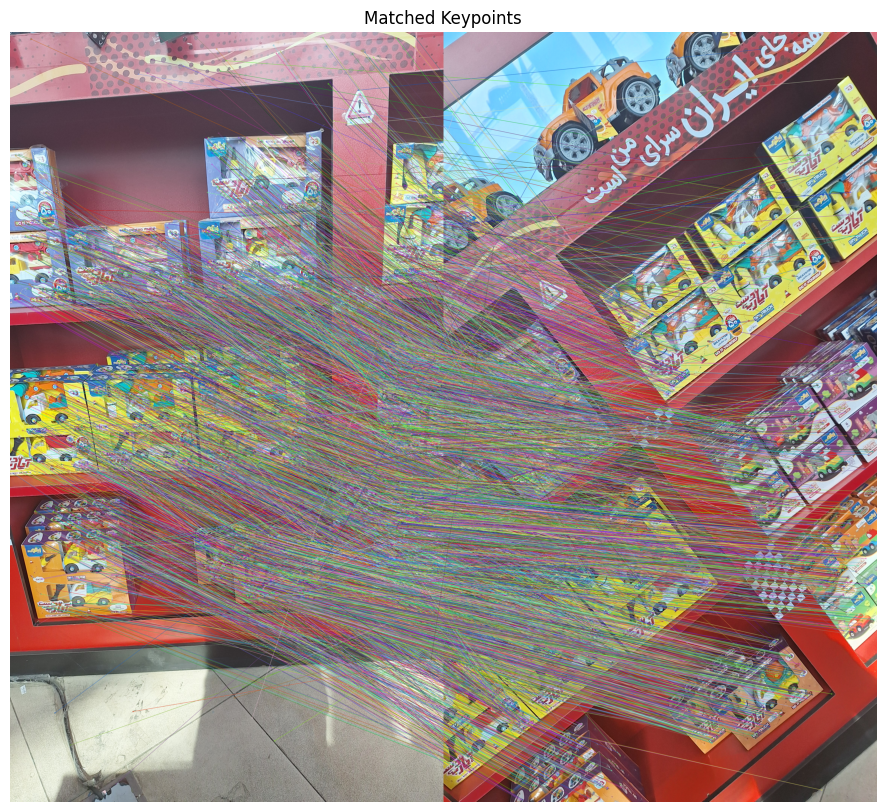

In [9]:
# Match descriptors using BFMatcher
bf = cv2.BFMatcher()

# Find the best two matches for each descriptor
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

# Apply ratio test (Lowe's ratio test)
good_matches = []
ratio_thresh = 0.75  
for m, n in matches:
    if m.distance < ratio_thresh * n.distance:
        good_matches.append(m)

img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.title('Matched Keypoints')
plt.axis('off')
plt.show()

c) as you can see in previous step there are stil some wrong matches. in this cases we can use ransac for detecting wrong matches or outliers. write a function for ransac manually. for this porpuse you need to use the fundamental matrix.  

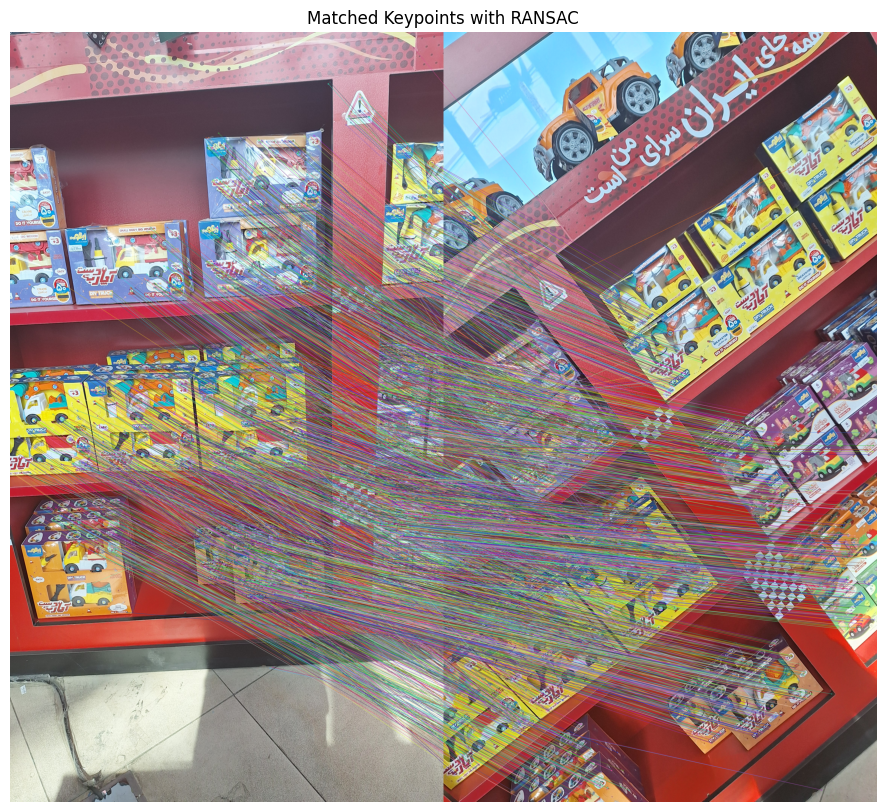

In [10]:
def find_fundamental_matrix_ransac(matches, keypoints1, keypoints2, threshold=0.01, max_iterations=1000):
    max_inliers = []
    best_F = None

    if len(matches) < 8:
        return None, []

    for _ in range(max_iterations):
        # Randomly sample 8 matches
        sample_matches = np.random.choice(matches, 8, replace=False)
        pts1 = np.float32([keypoints1[m.queryIdx].pt for m in sample_matches])
        pts2 = np.float32([keypoints2[m.trainIdx].pt for m in sample_matches])
        
        # Compute the fundamental matrix
        F, _ = cv2.findFundamentalMat(pts1, pts2, method=cv2.FM_8POINT)

        # Compute inliers
        inliers = []
        for m in matches:
            pt1 = np.array([*keypoints1[m.queryIdx].pt, 1.0])
            pt2 = np.array([*keypoints2[m.trainIdx].pt, 1.0])
            error = np.abs(pt2.T @ F @ pt1)
            if error < threshold:
                inliers.append(m)
        
        # Update the best set of inliers
        if len(inliers) > len(max_inliers):
            max_inliers = inliers
            best_F = F

    return best_F, max_inliers

F, inliers = find_fundamental_matrix_ransac(good_matches, keypoints1, keypoints2)

img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, inliers, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.title('Matched Keypoints with RANSAC')
plt.axis('off')
plt.show()

Use the final matches to calculate the fundamental matrix based on them. Then, compute the intrinsic matrix of your camera, assuming that 𝑆𝜃 is equal to zero. Ensure that your K matrix is logical.

In [11]:
pts1 = np.float32([keypoints1[m.queryIdx].pt for m in inliers])
pts2 = np.float32([keypoints2[m.trainIdx].pt for m in inliers])

F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_8POINT)

# K = [[fx, 0, cx],
#      [0, fy, cy],
#      [0,  0,  1]]
fx = 800  
fy = 800
cx = gray1.shape[1] / 2
cy = gray1.shape[0] / 2

K = np.array([[fx,  0, cx],
              [ 0, fy, cy],
              [ 0,  0,  1]])

print("Fundamental Matrix:\n", F)
print("Intrinsic Matrix K:\n", K)

Fundamental Matrix:
 [[ 1.03885205e-07 -1.43267325e-07  2.15610724e-04]
 [ 1.42221642e-07  1.01845104e-07 -3.77020634e-04]
 [-5.56976136e-04 -1.87617313e-04  1.00000000e+00]]
Intrinsic Matrix K:
 [[8.000e+02 0.000e+00 1.148e+03]
 [0.000e+00 8.000e+02 2.040e+03]
 [0.000e+00 0.000e+00 1.000e+00]]
